# Introduction to Machine Learning
## Lesson 10 Advanced training of Neural Networks in Pytorch
## Introduction

In this lab work, we will explore advanced techniques for training neural networks using PyTorch. These methods aim to enhance the efficiency, reliability, and speed of training neural networks.

## Objectives

Learn how to use:
1. Data augmentation
2. Batch normalization
3. Dropout
4. Early stopping
5. Learning rate scheduling
6. TensorBoard for training control

### Data Augmentation

Data augmentation involves creating new training examples by transforming the existing data, which helps improve the model's generalization. You will learn how to apply various data augmentation techniques to your dataset.

### Batch Normalization

Batch normalization standardizes the inputs to a layer for each mini-batch. This technique helps in speeding up the training process and improving the model's performance. You will implement batch normalization in your neural network layers.

### Dropout

Dropout is a regularization technique that helps prevent overfitting by randomly dropping units during training. You will learn how to apply dropout in your neural network.

### Early Stopping

Early stopping monitors the model's performance on a validation set and stops training when performance starts to degrade. This technique helps in preventing overfitting. You will implement early stopping in your training process.

### Learning Rate Scheduling

Learning rate scheduling adjusts the learning rate during training to improve convergence. You will explore different learning rate scheduling strategies and apply them to your training process.

### TensorBoard for Training Control

TensorBoard provides a suite of visualization tools to monitor and debug your training process. You will learn how to use TensorBoard to track metrics such as loss and accuracy, visualize the computational graph, and more.

# 1) Data augmentation
We're going to use a new dataset, CIFAR10, as our example for the task of classification. The data set consists of 60000 32x32 color images in 10 classes looking like this:

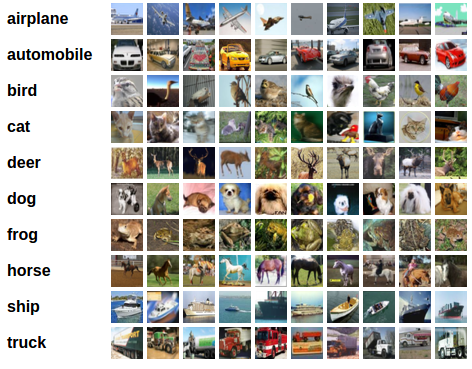

**Question: why might we use data augmentation? What problem does it solve?**

<span style="color:blue"> Data augmentation should help a model to learn on a more general data set by making random transforms of the samples. It solves (partially) the problem of overfitting.  

### Exercise 1

**1) Write the following augmentation transforms of CIFAR10 dataset:**

    - Crop (with size = 32, crop = 2) 
    - Horizontal flip (with probability 0.5)
    - Rotation (with 10 degrees max) 
    - Random affine (degrees = 0, shear = 10, scale=(0.8,1.2))
    
**2) Define DataLoader-s of CIFAR-10 with these transforms**

**Hint:** refer [ILLUSTRATION OF TRANSFORMS](https://pytorch.org/vision/stable/transforms.html) in Pytorch. 

In [1]:
import torch
from torch.utils import data
from torchvision import datasets, transforms

# You can increase these values if you've enough computational power
train_batch_size = 128
test_batch_size = 128

# Put augmentations
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
    transforms.RandomRotation(10),     #Rotates the image to a specified angel
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Do not modify test transforms, because it will corrupt test data
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# You should get how to get the training part of datasets.CIFAR10 and
# how to apply train_transforms here
# Specify path of downloaded set in root, if you've loaded it
train_dataset = datasets.CIFAR10(root='cifar10',
                                 train=True,
                                 transform=train_transforms,
                                 download=True)

# Define the loader of train data set: use train_batch_size as batch_size
# and don't forget to shuffle
train_data_loader = data.DataLoader(train_dataset,
                                    batch_size=train_batch_size,
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=2)


# Do the same for test part of CIFAR10, apply test_transforms
test_dataset = datasets.CIFAR10(root='cifar10',
                                 train=False,
                                 transform=test_transforms,
                                 download=True)

# Define the loader of test data set: use test_batch_size
test_data_loader = data.DataLoader(test_dataset,
                                    batch_size=test_batch_size,
                                    shuffle=False,
                                    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67058825..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5137255].


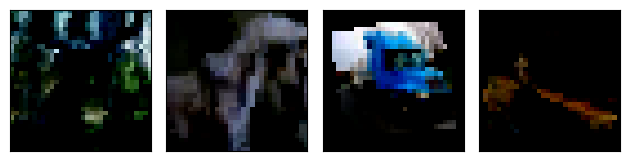

In [2]:
# Check the results of transformations
import matplotlib.pyplot as plt
images, _ = next(iter(train_data_loader))

fig, axs = plt.subplots(nrows=1, ncols=4)

for i in range(4):
    ax = axs[i]
    ax.imshow(images[i].numpy().transpose(1,2,0))
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
plt.tight_layout()
plt.show()

# 2) Build a model with dropout and batch normalization

Here we're going to build about the same model as we used before, but with two new layers: batch normalization and dropout.

#### Question: what's the purpose of these operations? What's the proposed order of their disposition relative to other layers?

<span style="color:blue"> Dropout is a regularization method that is used during the training on some layers: each neuron in these layers are "turn off" with probability p. It suppresses the difference in weights between the units.
    
<span style="color:blue"> Batch normalization scales the weights of a layer to make its mean equals to zero and variance equals to one. It impacts on stability of convergence to the optimum of the target function.
    
<span style="color:blue"> The proposed layout: Conv → Activation → MaxPool → BatchNormalization 
    
<span style="color:blue">  **or**
    
<span style="color:blue"> Dense → Activation → BatchNormalization → Dropout   

### Exercise 2

**Declare 4 blocks (nn.Sequential) of Custom model with the default parameters (unless otherwise stated):**

**1st block, convolutional)**

    - Convolution layer with 16 filters, kernel size equal to 3x3 and stride 1x1. Use ReLU as activation;
    - Max pool layer with kernel size 2;
    - Batch norm layer.
    
**2nd block, convolutional)**

    - Convolution layer with 32 filters, kernel size equal to 3x3 and stride 1x1. Use ReLU as activation;
    - Batch norm layer;
    - Dropout layer with probability of unit drop equal to 0.25.
    
**3rd block, convolutional)**

    - Convolution layer with 64 filters, kernel size equal to 3x3 and stride 1x1. Use ReLU as activation;
    - Batch norm layer;

**4th block, linear)**

    - Linear layer. If you stated the previous parameters properly, in_features should be 64*11*11. Set out_features as 256 and ReLU as activation;
    - Dropout layer with probability of unit drop equal to 0.1;
    - Final linear layer with size of output equals 10

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Build your model
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.linear1 = nn.Sequential(
            nn.Linear(64*11*11, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 10)
        )
        

    def forward(self, x):
        # Propagate x through the network
        # Do not forget to flatten after the 3rd block
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # Another way to flatten
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return F.log_softmax(x, dim=1)
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CustomModel().to(device)

print(f'Device: {device}')

print(model)

Device: cpu
CustomModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Sequential(
    (0): Linear(in_features=7744, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


# 3) Training pipeline upgrades: early stopping and LR scheduler

Early Stopping is a form of regularization, used to stop training when a monitored metric has stopped improving.


#### Question: what kind of metric can we monitor? What's the benefit of using early stopping?

<span style="color:blue"> It can be loss (with 'min' mode) or accuracy (with 'max' mode). Early stopping can prevent overfitting, as well as save some training time.

Vanila Pytorch doesn't contain early stopping (check [Pytorch Ignite](https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html) for 'official' solution), so we have to write it it from scratch. Although, sometimes it's useful to have such a custom tool which you can tune to your specific needs.

### Exercise 3

**Implement EarlyStopping class**

In [4]:
# Fill this class to stop when a certain value stop improving 
import operator
import numpy as np

class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        '''
        :param tolerance: number of epochs that the metric doesn't improve
        :param min_delta: minimum improvement
        :param mode: 'min' or 'max' to minimize or maximize the metric
        '''
        
        '''
        You should keep these parameters,
        define a counter of __call__ falses and the previous best value of metric
        '''
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf
        self.operation = operator.gt if mode == 'min' else operator.lt
        
    
    def __call__(self, metric)->bool:
        ''' This function should return True if `metric` is not improving for
            'tolerance' calls
        '''
        delta = (metric - self.prev_metric)

        if self.operation(delta, self.min_delta):
            self.counter +=1
        else:
            self.counter = 0
            self.prev_metric = metric

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop


### Let's look how different LR-schedulers work

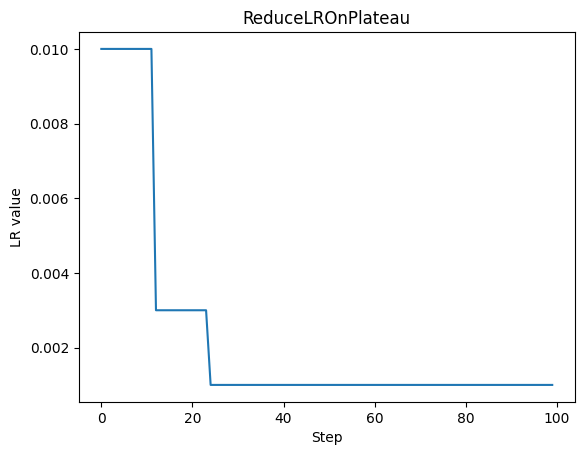

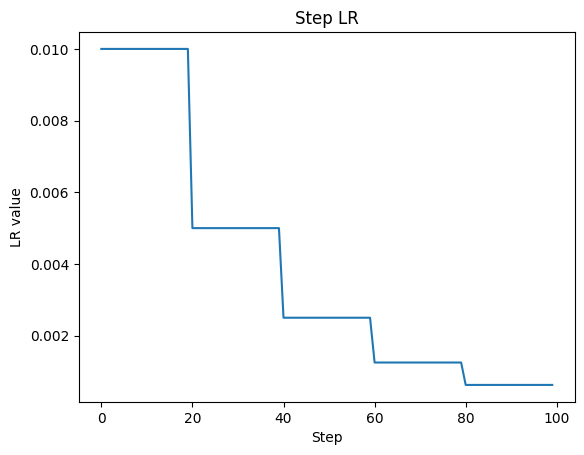

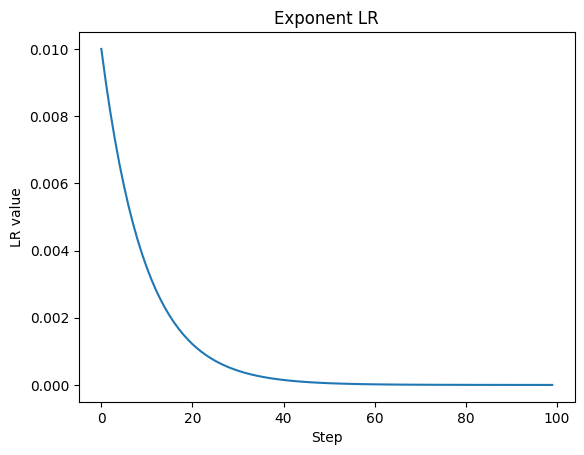

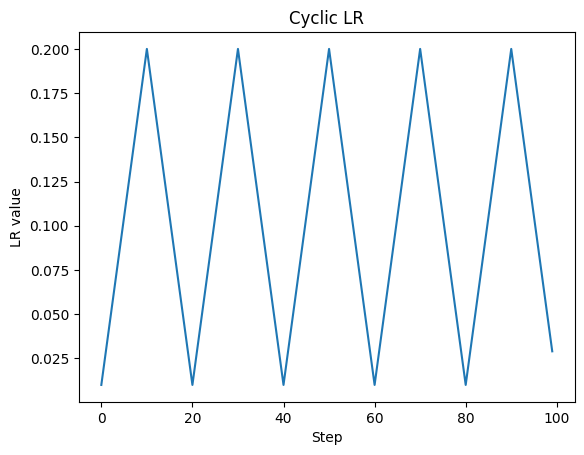

In [6]:
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Just a toy model 
class NullModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1,1)
    

toy_model = NullModule()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def plot_lr(scheduler, name):
    # Re-init for each scheduler
    optimizer.param_groups[0]['lr'] = 0.01
    optimizer.zero_grad()
    toy_model.zero_grad()
    lrs = []
    step = 100
    
    fig, ax = plt.subplots()
    ax.set(xlabel='Step', ylabel='LR value', title=name)

    for i in range(step):
        lr = optimizer.param_groups[0]['lr']
        if name == "ReduceLROnPlateau":
            scheduler.step(lr) 
        else:
            scheduler.step()
        lrs.append(lr)

    ax.plot(lrs)
    plt.show()
    
    
# You can check https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
LRs = {"ReduceLROnPlateau": lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, 
                                                           patience=10, verbose=True,min_lr=0.001),
       "Step LR": lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5),
       "Exponent LR": lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
       "Cyclic LR":lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.2, 
                                         cycle_momentum=False, step_size_up=10)}

for name, lr in LRs.items():
    plot_lr(lr, name)


# 4) Gather all together in training loops

This implementation of training and testing loops for a PyTorch model, designed to streamline the training process and evaluate model performance.

The `train` function handles the model's training phase by iterating over the training dataset, computing the loss using a given criterion, performing backpropagation, and updating model parameters with an optimizer. It also tracks and reports the training loss and accuracy for each epoch. 

The `test` function evaluates the trained model on a separate test dataset, calculating the test loss and accuracy without performing backpropagation. These functions leverage GPU acceleration if available and provide real-time progress updates using the `tqdm` library for better monitoring of the training process.

In [7]:
from time import time 
from tqdm import tqdm


def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0
    
    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss/iteration, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    print(f'\rTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss, acc


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

This code snippet sets up the training configuration for a PyTorch model, including the definition of hyperparameters, loss function, optimizer, learning rate scheduler, and early stopping mechanism. 

The `epochs` variable specifies the number of training iterations. 

The `criterion` is defined as CrossEntropyLoss, which is suitable for classification tasks. 

The optimizer is set to Stochastic Gradient Descent (SGD) with a learning rate of 0.1 and a momentum of 0.9, enhancing convergence speed and stability. 

The learning rate scheduler, `ReduceLROnPlateau`, reduces the learning rate by a factor of 0.3 if the monitored metric does not improve for 3 consecutive epochs, with a minimum learning rate of 0.001. 

The early stopping mechanism halts training if the validation loss does not improve for 7 epochs, preventing overfitting. Finally, `best_model_wts` stores a deep copy of the model's initial state, ensuring the best model weights can be restored after training.

In [8]:
from torch.optim import SGD
from copy import deepcopy

# Define hyperparams
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
# Choose the LR you like
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, 
                                                           patience=3, verbose=True, min_lr=0.001)
early_stopping = EarlyStopping(tolerance=7, mode='min')

best_model_wts = deepcopy(model.state_dict())

# 5) Use TensorBoard to check the progress of learning


This code defines a `training` function to train and evaluate a PyTorch model. If `writing` is `True`, it logs metrics to TensorBoard. The function iterates over epochs, updating model weights using a specified optimizer and learning rate scheduler. It calculates training and test losses and accuracies. Early stopping halts training if the test loss stops improving. The best model weights are saved if test accuracy improves. Finally, the model's state is saved to disk. This setup ensures efficient model training, evaluation, and optional logging.

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import copy



def training(writing=False):
    if writing:
        writer = SummaryWriter(log_dir='runs/model')
    best_acc = 0.0
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_data_loader, criterion, optimizer, epoch)
        # Update learning rate if needed
        scheduler.step(train_loss)

        test_loss, test_acc = test(model, device, test_data_loader, criterion)
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss):
            print('\nEarly stopping\n')
            break
        # Deep copy the weight of model if its accuracy is the best for now
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if writing:
            writer.add_scalars('Loss',
                            {
                                'train': train_loss,
                                'test': test_loss
                            },
                            epoch)

            writer.add_scalars('Accuracy',
                            {
                                'train': train_acc,
                                'test': test_acc
                            },
                            epoch)
        else:
            print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
            print(f"Training loss {train_loss}, test loss {test_loss}")
        
    torch.save(model.state_dict(), "model.pt")
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_model.pt")
    if writing:
        writer.close()
        
training()

### Conclusion

In this lab, you will implement advanced techniques to improve the training of neural networks. By using data augmentation, batch normalization, dropout, early stopping, learning rate scheduling, and TensorBoard, you will enhance the efficiency, reliability, and performance of your neural network models.